In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Audi.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_100 Serisi,Seri_200 Serisi,Seri_80 Serisi,...,Model_S3 2.0 TFSI Quattro,Model_S5 3.0 TFSI Quattro,Model_S7 4.0 TFSI Quattro,Model_S8 4.0 TFSI Quattro,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,839000,0.363636,0.222222,0.182692,-0.464419,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,1650000,0.545455,2.444444,1.961538,0.524345,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,1235000,0.818182,1.333333,-0.298077,-0.962547,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,785000,0.363636,0.222222,0.182692,0.082397,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,835000,0.363636,1.333333,1.961538,0.284644,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_12140\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,344676.425211,1.618736e+11,402335.191189,141740.264936


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 20:32:44,617] A new study created in memory with name: no-name-6d147805-c41a-4c5a-98ae-bc103cc67036
[I 2023-05-23 20:32:44,877] Trial 2 finished with value: 958881.6675354512 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.27710930175351717, 'max_depth': 3, 'min_child_weight': 226}. Best is trial 2 with value: 958881.6675354512.
[I 2023-05-23 20:32:44,896] Trial 7 finished with value: 1169517.8312903768 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.4206841604955131, 'max_depth': 7, 'min_child_weight': 298}. Best is trial 2 with value: 958881.6675354512.
[I 2023-05-23 20:32:44,900] Trial 0 finished with value: 1570869.826134318 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.005598232472946539, 'max_depth': 7, 'min_child_weight': 133}. Best is trial 2 with value: 958881.6675354512.
[I 2023-05-23 20:32:44,901] Trial 1 finished with value: 1605586.37297155 and parameters: {'colsamp

[I 2023-05-23 20:32:46,909] Trial 30 finished with value: 979563.4672876152 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.13113772314357525, 'max_depth': 5, 'min_child_weight': 194}. Best is trial 24 with value: 901784.7190182132.
[I 2023-05-23 20:32:46,910] Trial 31 finished with value: 967903.1203430857 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.1373781063196833, 'max_depth': 5, 'min_child_weight': 179}. Best is trial 24 with value: 901784.7190182132.
[I 2023-05-23 20:32:46,973] Trial 33 finished with value: 1048870.7581417733 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.09981333755180267, 'max_depth': 5, 'min_child_weight': 184}. Best is trial 24 with value: 901784.7190182132.
[I 2023-05-23 20:32:46,995] Trial 32 finished with value: 983167.5351789756 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.1269531525810944, 'max_depth': 5, 'min_child_weight':

[I 2023-05-23 20:32:49,024] Trial 60 finished with value: 1280856.197705221 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.0381530288012378, 'max_depth': 8, 'min_child_weight': 55}. Best is trial 37 with value: 789705.7923229036.
[I 2023-05-23 20:32:49,213] Trial 61 finished with value: 1231623.9027831317 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.05354312206396417, 'max_depth': 8, 'min_child_weight': 106}. Best is trial 37 with value: 789705.7923229036.
[I 2023-05-23 20:32:49,346] Trial 62 finished with value: 1184353.4481906802 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.06270659639461328, 'max_depth': 7, 'min_child_weight': 98}. Best is trial 37 with value: 789705.7923229036.
[I 2023-05-23 20:32:49,448] Trial 65 finished with value: 1169191.7311932647 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.056693420146790796, 'max_depth': 11, 'min_child_weigh

[I 2023-05-23 20:32:51,593] Trial 93 finished with value: 321551.55647119146 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4132454285812495, 'max_depth': 15, 'min_child_weight': 3}. Best is trial 93 with value: 321551.55647119146.
[I 2023-05-23 20:32:51,613] Trial 90 finished with value: 371788.51112139696 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4167219191226572, 'max_depth': 15, 'min_child_weight': 4}. Best is trial 93 with value: 321551.55647119146.
[I 2023-05-23 20:32:51,629] Trial 92 finished with value: 318048.06073859066 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4119278586348912, 'max_depth': 15, 'min_child_weight': 3}. Best is trial 92 with value: 318048.06073859066.
[I 2023-05-23 20:32:51,657] Trial 94 finished with value: 367594.05139300367 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4267115976271635, 'max_depth': 15, 'min_child_weight

[I 2023-05-23 20:32:54,843] Trial 121 finished with value: 422633.7115023978 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.2651698109595505, 'max_depth': 13, 'min_child_weight': 8}. Best is trial 106 with value: 312327.2077160687.
[I 2023-05-23 20:32:54,861] Trial 120 finished with value: 448261.42053031025 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.2589426870262056, 'max_depth': 13, 'min_child_weight': 9}. Best is trial 106 with value: 312327.2077160687.
[I 2023-05-23 20:32:54,867] Trial 123 finished with value: 518494.41963920946 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.26151528554032977, 'max_depth': 13, 'min_child_weight': 10}. Best is trial 106 with value: 312327.2077160687.
[I 2023-05-23 20:32:54,870] Trial 122 finished with value: 439226.27775089664 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.24786460923245857, 'max_depth': 13, 'min_child_

[I 2023-05-23 20:32:57,328] Trial 150 finished with value: 593492.1337838798 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.22440582219230518, 'max_depth': 14, 'min_child_weight': 13}. Best is trial 131 with value: 283852.3783052288.
[I 2023-05-23 20:32:57,501] Trial 152 finished with value: 520948.65274654224 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.4949576307148849, 'max_depth': 14, 'min_child_weight': 13}. Best is trial 131 with value: 283852.3783052288.
[I 2023-05-23 20:32:57,519] Trial 151 finished with value: 438354.19694774214 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.499203842734756, 'max_depth': 14, 'min_child_weight': 14}. Best is trial 131 with value: 283852.3783052288.
[I 2023-05-23 20:32:57,847] Trial 155 finished with value: 371889.7157370354 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.2987901076399181, 'max_depth': 14, 'min_child_w

[I 2023-05-23 20:32:59,845] Trial 180 finished with value: 333302.8559427279 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.34655526260013647, 'max_depth': 14, 'min_child_weight': 1}. Best is trial 131 with value: 283852.3783052288.
[I 2023-05-23 20:32:59,879] Trial 182 finished with value: 339105.50635267055 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.4993133938234526, 'max_depth': 14, 'min_child_weight': 1}. Best is trial 131 with value: 283852.3783052288.
[I 2023-05-23 20:32:59,937] Trial 183 finished with value: 318553.3732070396 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.34330754232057936, 'max_depth': 14, 'min_child_weight': 1}. Best is trial 131 with value: 283852.3783052288.
[I 2023-05-23 20:32:59,965] Trial 181 finished with value: 384488.452974313 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.3510729965757456, 'max_depth': 14, 'min_child_weig

[I 2023-05-23 20:33:02,180] Trial 210 finished with value: 1605406.7869176746 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.0011957733261666011, 'max_depth': 15, 'min_child_weight': 2}. Best is trial 202 with value: 273905.0860917551.
[I 2023-05-23 20:33:02,622] Trial 213 finished with value: 399388.9533819694 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.42154333176728603, 'max_depth': 15, 'min_child_weight': 8}. Best is trial 202 with value: 273905.0860917551.
[I 2023-05-23 20:33:02,624] Trial 212 finished with value: 412245.6116828838 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.4303514050678278, 'max_depth': 15, 'min_child_weight': 8}. Best is trial 202 with value: 273905.0860917551.
[I 2023-05-23 20:33:02,699] Trial 211 finished with value: 379417.15974982205 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.42318679138392823, 'max_depth': 15, 'min_child

[I 2023-05-23 20:33:05,668] Trial 243 finished with value: 1536808.0620618893 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.006836174362916796, 'max_depth': 13, 'min_child_weight': 11}. Best is trial 202 with value: 273905.0860917551.
[I 2023-05-23 20:33:05,695] Trial 240 finished with value: 469588.73473963107 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.3638799440846894, 'max_depth': 13, 'min_child_weight': 11}. Best is trial 202 with value: 273905.0860917551.
[I 2023-05-23 20:33:05,714] Trial 241 finished with value: 810928.1735220061 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.10574261788046595, 'max_depth': 13, 'min_child_weight': 11}. Best is trial 202 with value: 273905.0860917551.
[I 2023-05-23 20:33:05,734] Trial 242 finished with value: 1540693.4149286365 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.00650771195221663, 'max_depth': 13, 'min_ch

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 273905.0861
Best params:
	colsample_bytree: 0.9
	subsample: 0.8
	learning_rate: 0.3447106450988352
	max_depth: 15
	min_child_weight: 1


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.3],
                  "max_depth": [9,15],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [0.9],
               'subsample': [0.8],
               'min_child_weight': [1]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 0.9, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 750, 'subsample': 0.8}
{'TestDeger': 336553.1852296203, 'MSE': 76159982806.77078, 'RMSE': 275970.9818201377, 'MAE': 131382.6841733871}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9439799811255579

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.9301040547914508

In [16]:
marka_model = joblib.dump(grid_final_model, "Audi.pkl")

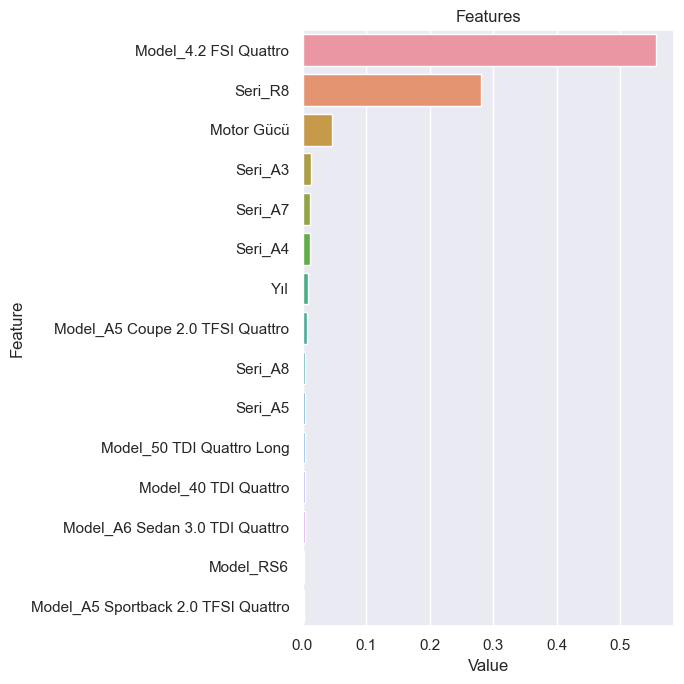

In [25]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)

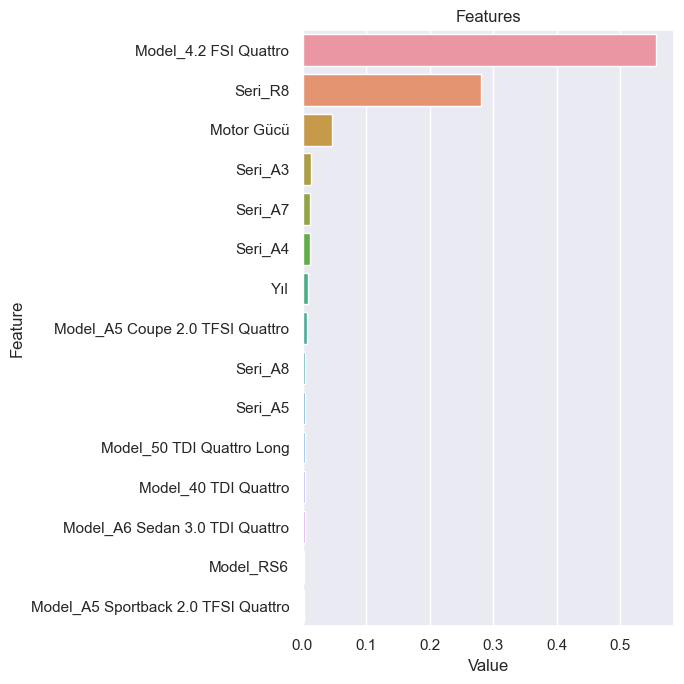

In [18]:
y_test2 = list(y_test)

In [19]:
df3 = pd.DataFrame(list(zip(y_test, y_pred,(y_pred-y_test))),
               columns =['test', 'pred',"fark"])

In [20]:
df3

,test,pred,fark
0,1150000,1.537799e+06,387798.87500
1,1750000,1.850959e+06,100958.87500
2,880000,7.953524e+05,-84647.62500
3,429000,4.792031e+05,50203.09375
4,2750000,3.051914e+06,301914.00000
...,...,...,...
460,585000,6.227404e+05,37740.37500
461,1250000,1.196974e+06,-53026.00000
462,2925000,2.747184e+06,-177815.75000
463,390000,3.974087e+05,7408.65625


In [21]:
df3.describe([0.05,0.25, 0.75,0.90,0.99]).T

,count,mean,std,min,5%,25%,50%,75%,90%,99%,max
test,471.0,399862.191083,229039.974623,9.050000e+04,177500.000000,290000.000000,390000.000,465000.000000,559500.00000,754500.00000,4.350000e+06
pred,471.0,386051.937500,130966.945312,1.014875e+05,175274.164062,293813.562500,381125.250,463002.890625,542972.93750,760347.36875,9.096226e+05
fark,471.0,-13810.275743,189582.255273,-3.900788e+06,-77647.359375,-26970.515625,-308.375,21781.187500,42974.09375,98623.87500,2.873716e+05


In [22]:
df3["test"].max()

4350000

In [23]:
df3[df3["test"]==4350000]

,test,pred,fark
428,4350000,449211.78125,-3.900788e+06


In [25]:
df3[df3["test"] > 1000000]

,test,pred,fark
173,1100003,190055.484375,-9.099475e+05
273,1150000,909622.562500,-2.403774e+05
428,4350000,449211.781250,-3.900788e+06


In [33]:
y_train2 = list(y_train)

In [39]:
for i in y_train2:
    if i > 1000000:
        print(i)

1105000
